## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Hint for your task 2)
#### You must implement your filtering / smoothing in the HMMFilter / HMMSmoother classes in the file Filters. For the filter, this means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localiser. Note also, that you must make use of the given models and the robot simulator in RobotSim!


Average Manhattan Distance (Filter): 1.786
Average Manhattan Distance (Smoother): 1.8548387096774193


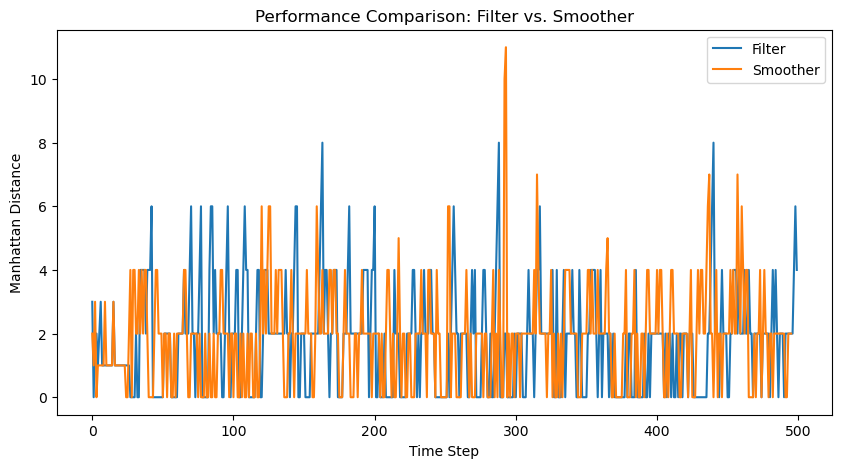

In [8]:
from models import *
from Filters import HMMFilter, HMMSmoother
from models.ObservationModel_NUF import ObservationModel

import numpy as np
import matplotlib.pyplot as plt
import random

# Grid dimensions
rows = 8
cols = 8

# Create StateModel, TransitionModel, and ObservationModel
sm = StateModel(rows, cols)
tm = TransitionModel(sm)
om = ObservationModel(sm)  

# Initialize HMMFilter and HMMSmoother
prior = np.ones(sm.get_num_of_states()) / sm.get_num_of_states()
hmm_filter = HMMFilter(prior, tm, om, sm)
hmm_smoother = HMMSmoother(tm, om, sm)

# Create RobotSim
true_state = random.randint(0, sm.get_num_of_states() - 1)
rs = RobotSim(true_state, sm)

# Simulation parameters
num_steps = 500
smoothing_window = 5

# Store results
filter_distances = []
smoother_distances = []

# Store sensor readings for smoothing
sensor_readings = []

# Simulation loop
for i in range(num_steps):
    # Move the robot
    true_state = rs.move_once(tm)
    
    # Get the observation
    observation = rs.sense_in_current_state(om)
    sensor_readings.append(observation)
    
    # Get the filter belief
    filter_belief = hmm_filter.filter(observation)
    
    # Calculate Manhattan distance for filter
    filter_estimate = sm.state_to_position(np.argmax(filter_belief))
    true_position = sm.state_to_position(true_state)
    filter_distance = abs(true_position[0] - filter_estimate[0]) + abs(true_position[1] - filter_estimate[1])
    filter_distances.append(filter_distance)
    
    # Perform smoothing if we have enough sensor readings
    if len(sensor_readings) >= smoothing_window:
        smoother_belief = hmm_smoother.smooth(sensor_readings[-smoothing_window:], filter_belief)
        smoother_estimate = sm.state_to_position(np.argmax(smoother_belief))
        smoother_distance = abs(true_position[0] - smoother_estimate[0]) + abs(true_position[1] - smoother_estimate[1])
        smoother_distances.append(smoother_distance)
    else:
        smoother_distances.append(None)

# Calculate average Manhattan distance for filter and smoother
average_filter_distance = np.mean(filter_distances)
average_smoother_distance = np.mean([d for d in smoother_distances if d is not None])

print(f"Average Manhattan Distance (Filter): {average_filter_distance}")
print(f"Average Manhattan Distance (Smoother): {average_smoother_distance}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(filter_distances, label="Filter")
plt.plot([d for d in smoother_distances if d is not None], label="Smoother")
plt.xlabel("Time Step")
plt.ylabel("Manhattan Distance")
plt.title("Performance Comparison: Filter vs. Smoother")
plt.legend()
plt.show()
